<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EA%B5%90%EA%B3%BC%EC%84%9C_ch2_4_p_69~87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.4 파이토치 코드 맛보기

PyTorch를 사용해 자동차 상태(output)을 예측하는 분류 모델을 만들어보는 예제

사용할 데이터: `chap02/data/car_evaluation.csv`

이 데이터는 총 7개의 열(칼럼)로 구성:

1. price (자동차 가격)
2. maint (유지 비용)
3. doors (문 개수)
4. persons (수용 인원)
5. lug\_capacity (수하물 용량)
6. safety (안전성)
7. output (자동차 상태) → 예측 대상

output 열:

* unacc (허용 불가능한 수준)
* acc (허용 가능한 수준)
* good (양호)
* vgood (매우 좋음)

목표 : 위의 1\~6번 특성 정보를 사용하여 7번째 열인 output(자동차 상태)을 예측하는 분류 모델을 만드는 것

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/25-1 ESAA OB/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


- 컴퓨터는 인간의 언어인 단어를 인식할 수 없기 때문에 단어를 벡터로 바꾸어주는 임베딩(embedding) 처리가 필요

<Axes: ylabel='count'>

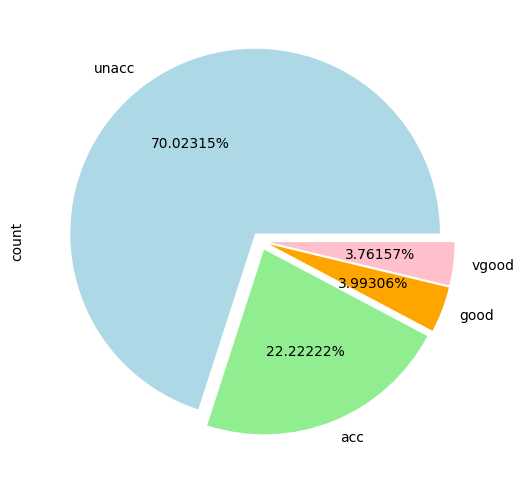

In [6]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams['figure.figsize'] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct = '%0.05f%%',
                                   colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05, 0.05))

- 대부분의 자동차(70%)는 허용 불가능한 상태, 20%만 허용 가능한 수준
- 즉，양호한 상태의 자동차 비율이 매우 낮은 것을 알 수 있음

- 딥러닝 모델은 **문자 데이터를 숫자(텐서)**로 바꿔야 함

- 예제의 모든 데이터는 범주형이므로 숫자로 인코딩 필요

- astype('category')로 변환한 후 LabelEncoder로 숫자 처리

In [9]:
from re import L
categorical_columns = ['price', 'maint','doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
  dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

범주형 데이터 → 숫자 → 텐서 순으로 변환 필요

- cat.codes: 범주형 데이터를 **숫자(정수)**로 변환

- np.array 또는 np.stack: 넘파이 배열로 만들어 PyTorch 텐서로 변환 가능

- np.stack은 여러 배열을 하나로 합칠 때 사용

- torch 모률을 이용하여 배열을 텐서로 변환

In [10]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

- 레이블(outputs)로 사용할 칼럼에 대해서도 텐서로 변환
- get_dummies를 이용하여 넘파이 배열로 변환

In [11]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() # 1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


- **get_dummies()** : 범주형 데이터를 **가변수(dummy variable)**로 변환

- 각 범주 값을 0과 1의 이진 변수로 바꿔줌 (원-핫 인코딩)

In [12]:
import pandas as pd
import numpy as np

data={
    'gender' : ['male', 'female', 'male'],
    'weight' : [72,55,68],
    'nation' : ['Japan', 'Korea', 'Austrailia']
}

df = pd.DataFrame(data)
df

,gender,weight,nation
0,male,72,Japan
1,female,55,Korea
2,male,68,Austrailia


In [14]:
pd.get_dummies(df, dtype=int)

,weight,gender_female,gender_male,nation_Austrailia,nation_Japan,nation_Korea
0,72,0,1,0,1,0
1,55,1,0,0,0,1
2,68,0,1,1,0,0


차원 변경 함수 요약

- ravel(): 다차원 배열을 1차원으로 펼침. 원본 배열을 변경

- reshape(-1): 다차원 배열을 1차원으로 변환하지만, 원본 배열은 변경하지 않음

- flatten(): 다차원 배열을 1차원으로 변환하고, 원본 배열과는 독립적인 복사본을 생성

- 워드 임베딩 : 유사한 단어를 비슷한 숫자 벡터로 변환하여 단어 간의 관계를 잘 표현하는 방법

- 임베딩 크기 결정: 각 범주형 칼럼의 고유 값 수를 2로 나눈 값으로 임베딩 크기를 설정하는 경우가 많음

In [15]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [17]:
total_records = 1728
test_records = int(total_records * .2) # 전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [18]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


- 모델의 네트워크를 생성

In [19]:
class Model(nn.Module): ### 1
    def __init__(self, embedding_size, output_size, layers, p=0.4): ### 2
        super().__init__() ### 3
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,
                                     nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols #입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size 변수에 저장

        for i in layers: ### 4
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical): ### 5
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
           embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1) #넘파이의 concatenate와 같지만 대상이 텐서
        x = self.embedding_dropout(x)
        x = self.layers(x)

        return x

### 클래스 기반 모델 구현 요약

1. nn.Module 상속: 모델은 nn.Module을 상속받아 구현

2. __init__():

- 모델에서 사용할 파라미터와 신경망을 초기화
- 객체 생성 시 자동으로 호출

- self: 첫 번째 파라미터로, 클래스 객체를 의미

- 주요 매개변수:

 - embedding_size: 범주형 칼럼의 임베딩 크기

 - output_size: 출력층 크기

 - layers: 네트워크 계층 목록

 - p: 드롭아웃 확률 (기본값 0.5)

3. super().__init__(): 부모 클래스인 nn.Module의 초기화 함수에 접근

4. 계층 추가:

- Linear: 입력에 선형 변환을 적용 (y = Wx + b)

- ReLU: 활성화 함수

- BatchNorm1d: 배치 정규화

- Dropout: 과적합 방지를 위한 드롭아웃

5. forward():

- 학습 데이터를 입력받아 연산을 수행하는 함수

- 모델 객체를 호출할 때 자동으로 실행

In [20]:
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


- 손실 함수 : 분류 문제에서는 크로스 엔트로피 (cross entropy) 손실 함수를 사용

- 옵티마이저 : 아담(Adam) 옵티마이저를 사용하여 모델의 파라미터를 업데이트

In [21]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

- GPU가 있다면 GPU를 사용하고, 없으면 CPU를 사용하도록 설정

In [23]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

- 모델 학습

In [24]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs): # for문은 500회 반복되며, 각 반복마다 손실 함수가 오차를 계산
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss) # 반복할 때마다 오차를 aggregated_losses에 추가

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward() # 가중치를 업데이트하기 위해 손실 함수의 backward() 메서드 호출
    optimizer.step() # 옵티마이저 함수의 step() 메서드를 이용하여 기울기 업데이트


print(f'epoch: {i:3} loss: {single_loss.item():10.10f}') # 오차가 25 에포크마다 출력

epoch:   1 loss: 1.58890975
epoch:  26 loss: 1.37885916
epoch:  51 loss: 1.26201272
epoch:  76 loss: 1.15445042
epoch: 101 loss: 1.06120133
epoch: 126 loss: 0.94998729
epoch: 151 loss: 0.81934112
epoch: 176 loss: 0.73555529
epoch: 201 loss: 0.70335609
epoch: 226 loss: 0.66044331
epoch: 251 loss: 0.63784844
epoch: 276 loss: 0.61568844
epoch: 301 loss: 0.60722989
epoch: 326 loss: 0.59877270
epoch: 351 loss: 0.59741795
epoch: 376 loss: 0.57668209
epoch: 401 loss: 0.57995480
epoch: 426 loss: 0.57843196
epoch: 451 loss: 0.57169217
epoch: 476 loss: 0.57831413
epoch: 500 loss: 0.5665143132


- 테스트 데이터셋으로 예측을 진행

In [25]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
  y_val = model(categorical_test_data)
  loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.56359893


In [26]:
# 모델의 예측 확인
print(y_val[:5])

tensor([[ 2.2550,  1.5952, -3.0389, -3.1576],
        [ 2.7502,  1.3689, -4.3032, -4.7243],
        [ 3.2570,  2.0416, -3.6838, -3.8061],
        [ 2.1222,  1.3349, -2.3585, -2.4991],
        [ 3.7154,  2.5157, -6.5729, -6.4821]])


- 목록에서 가장 큰 값을 갖는 인텍스 확인

In [27]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


- 출력 결과 모두 인텍스 0이 출력=> 즉, 인덱스가 0인 값이 인텍스가 1인 값보다 크므로 처리된 출력이 0임을 확인할 수 있음

- 테스트 데이터셋을 이용한 정확도 확인

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[259   0]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.00      0.00      0.00        86

    accuracy                           0.75       345
   macro avg       0.38      0.50      0.43       345
weighted avg       0.56      0.75      0.64       345

0.7507246376811594


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- 75%의 정확도

###  분류 모델 성능 평가 지표

1. 용어 정리:

   * True Positive (TP): 모델이 ‘1’로 예측하고 실제 값도 ‘1’인 경우
   * True Negative (TN): 모델이 ‘0’으로 예측하고 실제 값도 ‘0’인 경우
   * False Positive (FP): 모델이 ‘1’로 예측했지만 실제 값은 ‘0’인 경우 (Type I 오류)
   * False Negative (FN): 모델이 ‘0’으로 예측했지만 실제 값은 ‘1’인 경우 (Type II 오류)

2. 성능 평가 지표:

   * 정확도 (Accuracy): 전체 예측 중 맞은 예측의 비율
   * 재현율 (Recall): 실제 ‘1’인 값 중 모델이 올바르게 예측한 비율
   * 정밀도 (Precision): 모델이 ‘1’로 예측한 값 중 실제로 ‘1’인 비율
   * F1-스코어: 정밀도와 재현율의 조화 평균으로, 두 지표의 균형을 맞춘 값


- **정확도 (Accuracy)**:
  $$
  Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **재현율 (Recall)**:
  $$
  Recall = \frac{TP}{TP + FN}
  $$

- **정밀도 (Precision)**:
  $$
  Precision = \frac{TP}{TP + FP}
  $$

- **F1-스코어 (F1 Score)**:
  $$
  F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
  $$  
